In [1]:
# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps
from matplotlib import colors
import matplotlib.path as mpath

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num

import os

import gsw
import pyresample
from xgcm import Grid

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read grid file for lon/lat coordinates
dg = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")
lat_rho_10km= dg.variables["lat_rho"]
lon_rho_10km = dg.variables["lon_rho"]
lat_u_10km= dg.variables["lat_u"]
lon_u_10km = dg.variables["lon_u"]
lat_v_10km= dg.variables["lat_v"]
lon_v_10km = dg.variables["lon_v"]
cor_10km = dg.variables["f"]
pm_10km = dg.variables["pm"]
pn_10km = dg.variables["pn"]
zice_10km = dg.variables["zice"]
h_10km = dg.variables["h"]
dg.close()
print('Print lon/lat_rho shapes',lon_rho_10km.shape, lat_rho_10km.shape)
print('Print lon/lat_rho shapes',lon_rho_10km[0:-1,0:-1].shape, lat_rho_10km[0:-1,0:-1].shape)

Print lon/lat_rho shapes (560, 630) (560, 630)
Print lon/lat_rho shapes (559, 629) (559, 629)


In [3]:
# def read_roms_ts_10km(exp_path):

#     # using xr.open_mfdataset

#     vars2drop = ["ubar","vbar","w","Hsbl","Hbbl","swrad"]

#     ds = xr.open_mfdataset(paths=exp_path + "ocean_avg_00*.nc" , chunks={'eta_rho': '200MB', 'xi_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False)

#     #- preserving 5-days avgs
#     temp = ds.variables["temp"].mean('ocean_time')
#     salt = ds.variables["salt"].mean('ocean_time')
#     # shflux = ds.variables["shflux"] 
#     # ssflux = ds.variables["ssflux"]
#     melt = ds.variables["m"].mean('ocean_time')

#     ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

#     Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
#     z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
#     print("Vtransform=2")
#     Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
#     z_w = ds.zeta + (ds.zeta + ds.h) * Zo_w + ds.zice

#     ds.close()
    
#     return temp, salt, melt

In [4]:
# OPEN_MFDTASET TAKES FOREVER TO PLOT ANYTHING!!!!

# try: decode_times=False
# from https://github.com/pydata/xarray/issues/1385

In [5]:
# load ROMS avg output

def read_roms_ts_10km(exp_path):
    for yr  in ['20']:
        ds = xr.open_dataset(exp_path + 'ocean_avg_00' + yr + '.nc')
        print('size temp and time length: ', ds.temp.shape, len(ds.salt.isel(xi_rho=20, eta_rho=100, s_rho=0)))
        temp_tmp = ds.variables["temp"]
        salt_tmp = ds.variables["salt"]
        zeta_tmp = ds.variables["zeta"]
        melt_tmp = ds.variables["m"]
        temp_tmp_ann = np.nanmean(temp_tmp, axis=0)
        salt_tmp_ann = np.nanmean(salt_tmp, axis=0)
        melt_tmp_ann = np.nanmean(melt_tmp, axis=0)
        
        print('size temp_tmp_ann = ', temp_tmp_ann.shape)

        ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

        if ds.Vtransform == 1:
            Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
            z_rho_tmp = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
            print("Vtransform=1")
        elif ds.Vtransform == 2:
            Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
            z_rho_tmp = ds.zeta + (ds.zeta + ds.h) * Zo_rho
            print("Vtransform=2")
        z_rho_tmp_ann = np.nanmean(z_rho_tmp, axis=0)

        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w_tmp = ds.zeta + (ds.zeta + ds.h) * Zo_w
        z_w_tmp_ann = np.nanmean(z_w_tmp, axis=0)

        # Handle interpolation from u and v grid to rho points:
        ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

        coords={'X':{'center':'xi_rho', 'inner':'xi_u'},
            'Y':{'center':'eta_rho', 'inner':'eta_v'},
            'Z':{'center':'s_rho', 'outer':'s_w'}}

        grid = Grid(ds, coords=coords, periodic=[])

        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta + ds.zice
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta + ds.zice

        ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
        ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')

#         ds['pm_v'] = grid.interp(ds.pm, 'Y')
#         ds['pn_u'] = grid.interp(ds.pn, 'X')
#         ds['pm_u'] = grid.interp(ds.pm, 'X')
#         ds['pn_v'] = grid.interp(ds.pn, 'Y')
#         ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u)
#         ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

#         ds['dx'] = 1/ds.pm
#         ds['dx_u'] = 1/ds.pm_u
#         ds['dx_v'] = 1/ds.pm_v
#         ds['dx_psi'] = 1/ds.pm_psi

#         ds['dy'] = 1/ds.pn
#         ds['dy_u'] = 1/ds.pn_u
#         ds['dy_v'] = 1/ds.pn_v
#         ds['dy_psi'] = 1/ds.pn_psi
        
#         ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
#         ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
#         ds['dz_u'] = grid.interp(ds.dz, 'X')
#         ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
#         ds['dz_v'] = grid.interp(ds.dz, 'Y')
#         ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

#         ds['dA'] = ds.dx * ds.dy

#         metrics = {
#             ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
#             ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
#             ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
#             ('X', 'Y'): ['dA'] # Areas
#         }
#         grid = Grid(ds, coords=coords, metrics=metrics, periodic=False)

#         u10_rho_sfc = np.zeros((12,560,630))
#         v10_rho_sfc = np.zeros((12,560,630))
#         u10_rho_bot = np.zeros((12,560,630))
#         v10_rho_bot = np.zeros((12,560,630))

#         for mm in np.arange(0,12):
#             #interpoate u, v to rho grid:
#             u10_interp = grid.interp(ds.u.isel(s_rho=0,ocean_time=mm), 'X',boundary='fill')
#             v10_interp = grid.interp(ds.v.isel(s_rho=0,ocean_time=mm), 'Y',boundary='fill')
#             u10_rho_bot[mm,:,:]=u10_interp
#             v10_rho_bot[mm,:,:]=v10_interp
#             del u10_interp,v10_interp
#             u10_interp = grid.interp(ds.u.isel(s_rho=-1,ocean_time=mm), 'X',boundary='fill')
#             v10_interp = grid.interp(ds.v.isel(s_rho=-1,ocean_time=mm), 'Y',boundary='fill')
#             u10_rho_sfc[mm,:,:]=u10_interp
#             v10_rho_sfc[mm,:,:]=v10_interp
#             del u10_interp,v10_interp

#         u10_rho_bot_ann = np.nanmean(u10_rho_bot, axis=0)
#         v10_rho_bot_ann = np.nanmean(v10_rho_bot, axis=0)
#         u10_rho_sfc_ann = np.nanmean(u10_rho_sfc, axis=0)
#         v10_rho_sfc_ann = np.nanmean(v10_rho_sfc, axis=0)
        # concantenate annual averaged temp/salt
        if yr == '20':
            temp_ann = temp_tmp_ann
            salt_ann = salt_tmp_ann
            melt_ann = melt_tmp_ann
            # u10_bot = u10_rho_bot_ann
            # v10_bot = v10_rho_bot_ann
            # u10_sfc = u10_rho_sfc_ann
            # v10_sfc = v10_rho_sfc_ann

    # return temp_ann, salt_ann, u10_sfc, v10_sfc, u10_bot, v10_bot, melt_ann
    return temp_ann, salt_ann, melt_ann


In [6]:
%%time
path_ECCO2_10km = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_01-20yr/'
temp_ann_10km, salt_ann_10km, melt_ann_10km = read_roms_ts_10km(path_ECCO2_10km)


size temp and time length:  (12, 31, 560, 630) 12
size temp_tmp_ann =  (31, 560, 630)
Vtransform=2
CPU times: user 9.63 s, sys: 8.56 s, total: 18.2 s
Wall time: 21.2 s


In [7]:
%%time
path_ECCO2_10km_new = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_Apr23/output_01-20yr/'
temp_ann_10km_new, salt_ann_10km_new, melt_ann_10km_new = read_roms_ts_10km(path_ECCO2_10km_new)


size temp and time length:  (12, 31, 560, 630) 12
size temp_tmp_ann =  (31, 560, 630)
Vtransform=2
CPU times: user 7.82 s, sys: 7.23 s, total: 15 s
Wall time: 18.6 s


In [8]:
%%time
path_ECCO2_10km_tnudg = '/scratch/gi0/fbd581/waom10extend_testcode/output_01-20yr_test_tnudg/'
temp_ann_10km_tnudg, salt_ann_10km_tnudg, melt_ann_10km_tnudg = read_roms_ts_10km(path_ECCO2_10km_tnudg)


path_ECCO2_10km_tnudg2 = '/scratch/gi0/fbd581/waom10extend_testcode/output_01-20yr_test_tnudg2/'
temp_ann_10km_tnudg2, salt_ann_10km_tnudg2, melt_ann_10km_tnudg2 = read_roms_ts_10km(path_ECCO2_10km_tnudg2)


size temp and time length:  (12, 31, 560, 630) 12
size temp_tmp_ann =  (31, 560, 630)
Vtransform=2
size temp and time length:  (12, 31, 560, 630) 12
size temp_tmp_ann =  (31, 560, 630)
Vtransform=2
CPU times: user 16.5 s, sys: 13.1 s, total: 29.6 s
Wall time: 33.8 s


In [9]:
mask_zice_10km = ma.masked_where(zice_10km < 0, np.ones(zice_10km.shape))
mask_outice_10km = ma.masked_where(zice_10km >= 0, np.ones(zice_10km.shape))

mask_shelf_10km = ma.masked_where(h_10km > 2000, np.ones(zice_10km.shape))


In [10]:
fig_path='/users/boeiradi/COLD_project/postprocessing/figs/Maps_validations/'

def lonlat_labels(ax):
    # latitude labels
    ax.text(120,-80,'80$^{\circ}$S',transform=ccrs.PlateCarree(),color='gray')
    ax.text(120,-70,'70$^{\circ}$S',transform=ccrs.PlateCarree(),color='gray')
    # longitude labels
    ax.text(0,-66,'0$^{\circ}$',transform=ccrs.PlateCarree(),color='gray')
    #ax.text(60,-53,'60$^{\circ}$E',transform=ccrs.PlateCarree(),color='gray')
    #ax.text(120,-53,'120$^{\circ}$E',transform=ccrs.PlateCarree(),color='gray')
    ax.text(-60,-48,'60$^{\circ}$W',transform=ccrs.PlateCarree(),color='gray')
    ax.text(-120,-48,'120$^{\circ}$W',transform=ccrs.PlateCarree(),color='gray')
    ax.text(180,-60,'180$^{\circ}$',transform=ccrs.PlateCarree(),color='gray')
    return

# define sections to investigate Ross-Filchner and Ross IS dynamics:
xi_pt = [850, 1000, 1275, 1550]
##xi_pt = [875, 1000, 1275, 1550] # new sections, too far east
eta_sec_ini = [1600, 1650,  750,  500]
eta_sec_end = [1945, 1970, 1075, 1196]

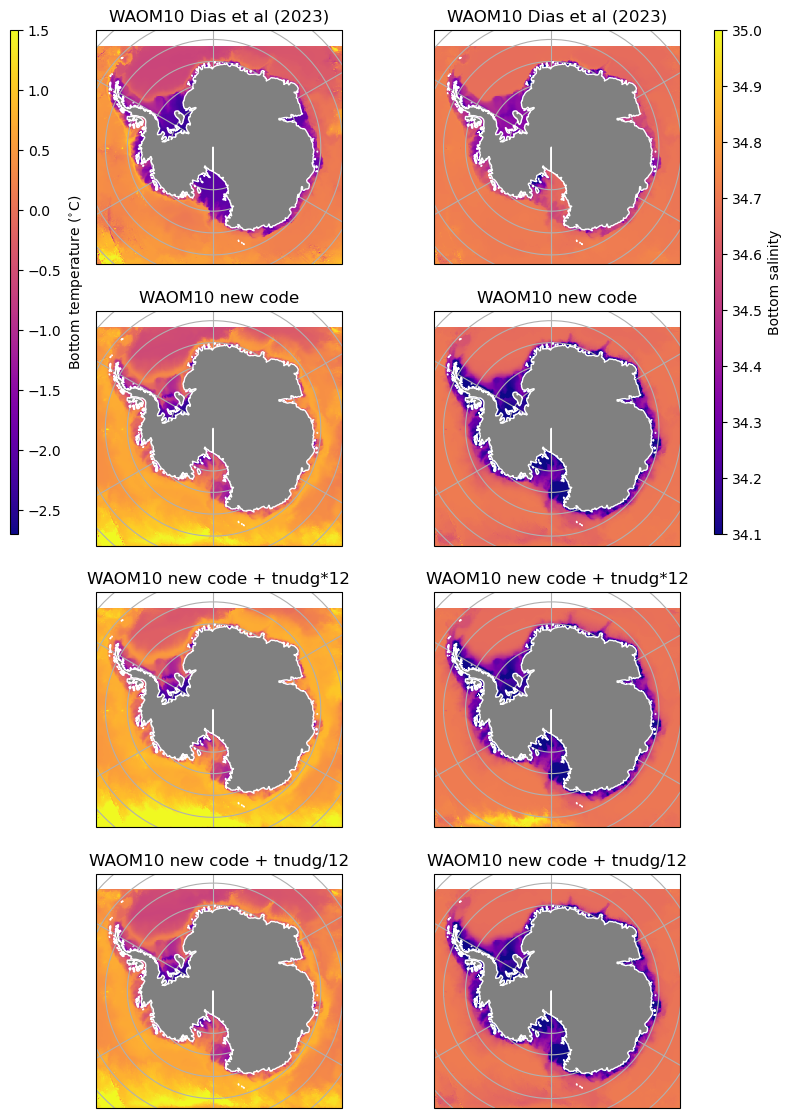

In [11]:
# call cartopy projection
proj = ccrs.SouthPolarStereo()

# ========== subregions plots:
# for 2000m isoline
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
# limits for contour of ice front (Ronne-Filchner IS):
xlimit = np.arange(300,500,1)
ylimit = np.arange(100,300,1)

# --- bottom

tmin = -2.7
tmax = 1.5
smin = 34.1
smax = 35.

fig = plt.figure(figsize=(8,14))

ax1 = fig.add_subplot(421, projection=proj)
# ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(temp_ann_10km[0,:,:])*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(temp_ann_10km[0,:,:]), transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
plt.title('WAOM10 Dias et al (2023)')
ax1.gridlines() # draw_labels=True,linewidth=
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax2 = fig.add_subplot(422, projection=proj)
# cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(salt_ann_10km[0,:,:])*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(salt_ann_10km[0,:,:]), transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
plt.title('WAOM10 Dias et al (2023)')
ax2.gridlines()
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax3 = fig.add_subplot(423, projection=proj)
# ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(temp_ann_10km_new[0,:,:])*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(temp_ann_10km_new[0,:,:]), transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
plt.title('WAOM10 new code')
ax3.gridlines() # draw_labels=True,linewidth=
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax4 = fig.add_subplot(424, projection=proj)
# cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(salt_ann_10km_new[0,:,:])*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(salt_ann_10km_new[0,:,:]), transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
plt.title('WAOM10 new code')
ax4.gridlines()
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax1 = fig.add_subplot(425, projection=proj)
# ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(temp_ann_10km[0,:,:])*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(temp_ann_10km_tnudg[0,:,:]), transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
plt.title('WAOM10 new code + tnudg*12')
ax1.gridlines() # draw_labels=True,linewidth=
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax2 = fig.add_subplot(426, projection=proj)
# cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(salt_ann_10km[0,:,:])*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(salt_ann_10km_tnudg[0,:,:]), transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
plt.title('WAOM10 new code + tnudg*12')
ax2.gridlines()
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax3 = fig.add_subplot(427, projection=proj)
# ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(temp_ann_10km_tnudg[0,:,:])*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(temp_ann_10km_tnudg2[0,:,:]), transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
plt.title('WAOM10 new code + tnudg/12')
ax3.gridlines() # draw_labels=True,linewidth=
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax4 = fig.add_subplot(428, projection=proj)
# cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(salt_ann_10km_tnudg[0,:,:])*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(salt_ann_10km_tnudg2[0,:,:]), transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
plt.title('WAOM10 new code + tnudg/12')
ax4.gridlines()
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

cbar_ax1 = fig.add_axes([0.04, 0.52, 0.01, 0.36])
fig.colorbar(ct1, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Bottom temperature ($^{\circ}$C)')#, labelpad=-35)

cbar_ax2 = fig.add_axes([0.92, 0.52, 0.01, 0.36])
fig.colorbar(cs1, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_ylabel('Bottom salinity')#, labelpad=-35)


plt.show()

In [ ]:
temp_ann_10km.shape

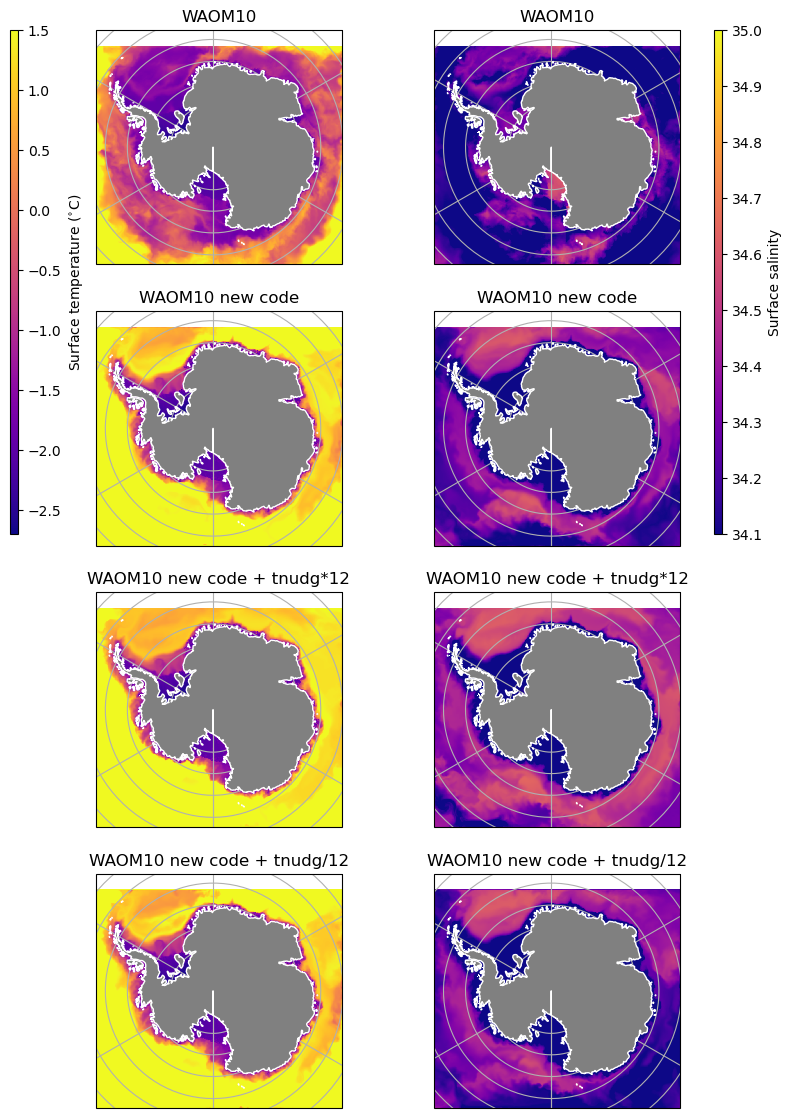

In [12]:
# --- surface

tmin = -2.7
tmax = 1.5
smin = 34.1
smax = 35.

fig = plt.figure(figsize=(8,14))

ax1 = fig.add_subplot(421, projection=proj)
# ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(temp_ann_10km[-1,:,:])*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(temp_ann_10km[-1,:,:]), transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
plt.title('WAOM10')
ax1.gridlines() # draw_labels=True,linewidth=
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax2 = fig.add_subplot(422, projection=proj)
# cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(salt_ann_10km[-1,:,:])*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(salt_ann_10km[-1,:,:]), transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
plt.title('WAOM10')
ax2.gridlines()
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax3 = fig.add_subplot(423, projection=proj)
# ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(temp_ann_10km_new[-1,:,:])*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(temp_ann_10km_new[-1,:,:]), transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
plt.title('WAOM10 new code')
ax3.gridlines() # draw_labels=True,linewidth=
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax4 = fig.add_subplot(424, projection=proj)
# cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(salt_ann_10km_new[-1,:,:])*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(salt_ann_10km_new[-1,:,:]), transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
plt.title('WAOM10 new code')
ax4.gridlines()
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax1 = fig.add_subplot(425, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(temp_ann_10km_tnudg[-1,:,:]), transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
plt.title('WAOM10 new code + tnudg*12')
ax1.gridlines() # draw_labels=True,linewidth=
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax2 = fig.add_subplot(426, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(salt_ann_10km_tnudg[-1,:,:]), transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
plt.title('WAOM10 new code + tnudg*12')
ax2.gridlines()
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax3 = fig.add_subplot(427, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(temp_ann_10km_tnudg2[-1,:,:]), transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
plt.title('WAOM10 new code + tnudg/12')
ax3.gridlines() # draw_labels=True,linewidth=
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax4 = fig.add_subplot(428, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(salt_ann_10km_tnudg2[-1,:,:]), transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
plt.title('WAOM10 new code + tnudg/12')
ax4.gridlines()
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

cbar_ax1 = fig.add_axes([0.04, 0.52, 0.01, 0.36])
fig.colorbar(ct1, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Surface temperature ($^{\circ}$C)')#, labelpad=-35)

cbar_ax2 = fig.add_axes([0.92, 0.52, 0.01, 0.36])
fig.colorbar(cs1, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_ylabel('Surface salinity')#, labelpad=-35)


plt.show()

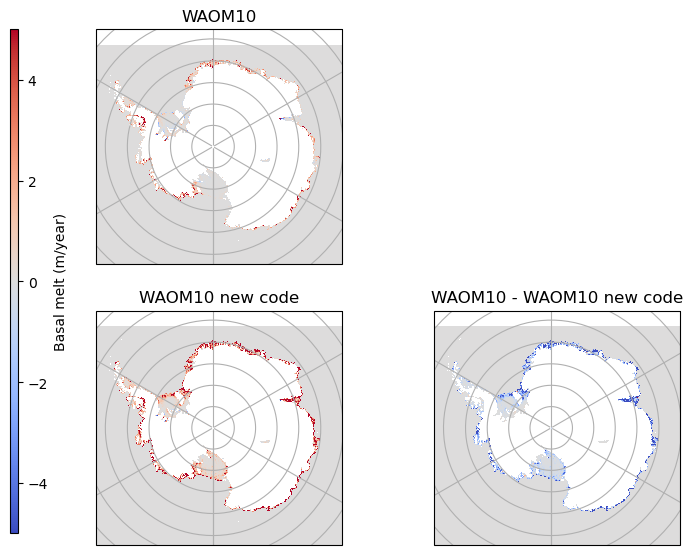

In [27]:
# --- basal melting

tmin = -5
tmax = 5


fig = plt.figure(figsize=(8,14))

ax1 = fig.add_subplot(421, projection=proj)
# ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(temp_ann_10km[-1,:,:])*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,melt_ann_10km*86400*365, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=tmin, vmax=tmax)
plt.title('WAOM10')
ax1.gridlines() # draw_labels=True,linewidth=
# ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax3 = fig.add_subplot(423, projection=proj)
# ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(temp_ann_10km_new[-1,:,:])*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,melt_ann_10km_new*86400*365, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=tmin, vmax=tmax)
plt.title('WAOM10 new code')
ax3.gridlines() # draw_labels=True,linewidth=
# ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax3 = fig.add_subplot(424, projection=proj)
# ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,np.squeeze(temp_ann_10km_new[-1,:,:])*mask_shelf_10km*mask_zice_10km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,(melt_ann_10km-melt_ann_10km_new)*86400*365, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=tmin, vmax=tmax)
plt.title('WAOM10 - WAOM10 new code')
ax3.gridlines() # draw_labels=True,linewidth=
# ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

cbar_ax1 = fig.add_axes([0.04, 0.52, 0.01, 0.36])
fig.colorbar(ct1, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Basal melt (m/year)')#, labelpad=-35)


plt.show()

In [19]:
melt_ann_10km_new.shape

(560, 630)